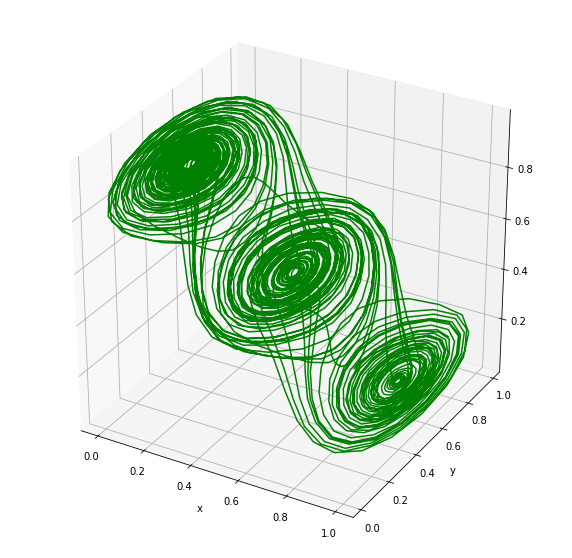

In [1]:
from dataset.chaotic_system import *
import numpy as np
from utils import *
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

path = 'result/onlinekmeans'
if not os.path.exists(path):
    os.makedirs(path)

names = [
#     'rossler',
#     'rabinovich_fabrikant',
#     'lorentz',
    'chua',
]


def show(x):
    x = np.atleast_2d(x)
    print(x.shape)
    plt.figure(figsize=(20, 6))
    dim = ['x', 'y', 'z']
    for i in range(x.shape[0]):
        plt.subplot(3, 1, i + 1)
        plt.plot(x[i, :].T, color='green', label='train set')
        plt.ylabel(dim[i])
        plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.show()


def show_3d(x, save=None):
    x = np.atleast_2d(x)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x[:3, :], 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(save)


n_dim = 3
horizon = 1
N = 10000
N_h = 200
num_prepare = 1000
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
n_history = 1
for system_name in names:     
    x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
    x += np.random.randn(*x.shape)*0.001

    x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
    y_train = select_samples(x, train_start+num_prepare + n_history + horizon - 1, num_train)
    x_test = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
    y_test = select_samples(x, test_start+num_prepare + n_history + horizon - 1, num_test)
    
    show_3d(x_train)

In [11]:
import numpy as np

def pairwise_l2_distances(X, Y):
    """
    A fast, vectorized way to compute pairwise l2 distances between rows in `X`
    and `Y`.
    Notes
    -----
    An entry of the pairwise Euclidean distance matrix for two vectors is
    .. math::
        d[i, j]  &=  \sqrt{(x_i - y_i) @ (x_i - y_i)} \\\\
                 &=  \sqrt{sum (x_i - y_j)^2} \\\\
                 &=  \sqrt{sum (x_i)^2 - 2 x_i y_j + (y_j)^2}
    The code below computes the the third line using numpy broadcasting
    fanciness to avoid any for loops.
    Parameters
    ----------
    X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, C)`
        Collection of `N` input vectors
    Y : :py:class:`ndarray <numpy.ndarray>` of shape `(M, C)`
        Collection of `M` input vectors. If None, assume `Y` = `X`. Default is
        None.
    Returns
    -------
    dists : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
        Pairwise distance matrix. Entry (i, j) contains the `L2` distance between
        :math:`x_i` and :math:`y_j`.
    """
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0  # clip any value less than 0 (a result of numerical imprecision)
    return np.sqrt(D)

class OnlineKMeans:
    """ Online K Means Algorithm """

    def __init__(self,
                 num_features: int,
                 num_clusters: int,
                 lr = None,
                 flag = True,
                 random_init = False
                ):
        """
        :param num_features: The dimension of the data
        :param num_clusters: The number of clusters to form as well as the number of centroids to generate.
        :param lr: The learning rate of the online k-means (c', t0). If None, then we will use the simplest update
        rule (c'=1, t0=0) as described in the lecture.
        """
        if num_features < 1:
            raise ValueError(f"num_features must be greater or equal to 1!\nGet {num_features}")
        if num_clusters < 1:
            raise ValueError(f"num_clusters must be greater or equal to 1!\nGet {num_clusters}")

        self.num_features = num_features
        self.num_clusters = num_clusters

        self.num_centroids = 0
        self.centroid = np.random.random((num_clusters, num_features)) if random_init else np.zeros((num_clusters, num_features))
        self.cluster_counter = np.zeros(num_clusters)  # Count how many points have been assigned into this cluster
        self.centroid_D = np.zeros((num_clusters, num_clusters))
        self.centroid_dist2neighbor = np.zeros((num_clusters, 1))

        self.num_samples = 0
        self.lr = lr
        self.flag = flag
        self.random_init = random_init

    def fit(self, X):
        """
        Receive a sample (or mini batch of samples) online, and update the centroids of the clusters
        :param X: (num_features,) or (num_samples, num_features)
        :return:
        """
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        num_samples, num_features = X.shape

        for i in range(num_samples):
            self.num_samples += 1
            # Did not find enough samples, directly set it to mean
            if not self.random_init and self.num_centroids < self.num_clusters:
                self.centroid[self.num_centroids] = X[i]
                self.cluster_counter[self.num_centroids] += 1
                self.num_centroids += 1
            else:
                # Determine the closest centroid for this sample
                sample = X[i]
                dist = np.linalg.norm(self.centroid - sample, axis=1)
                
                if self.flag:
                    self.centroid_D = pairwise_l2_distances(self.centroid, self.centroid) + 100 * np.eye(self.num_clusters)
                    self.centroid_dist2neighbor = np.min(self.centroid_D, axis=1)
                    if np.min(dist) > np.average(self.centroid_dist2neighbor) + np.std(self.centroid_dist2neighbor):
                        to_delete = np.argmin(self.centroid_dist2neighbor)
                        self.centroid[to_delete] = sample
                        self.cluster_counter[to_delete] = 0
                else:
                    centroid_idx = np.argmin(dist)

                    if self.lr is None:
                        self.centroid[centroid_idx] = (self.cluster_counter[centroid_idx] * self.centroid[centroid_idx] +
                                                       sample) / (self.cluster_counter[centroid_idx] + 1)
                        self.cluster_counter[centroid_idx] += 1
                    else:
    #                     c_prime, t0 = self.lr
    #                     rate = c_prime / (t0 + self.num_samples)
                        rate = self.lr
                        self.centroid[centroid_idx] = (1 - rate) * self.centroid[centroid_idx] + rate * sample
                        self.cluster_counter[centroid_idx] += 1

    def predict(self, X):
        """
        Predict the cluster labels for each sample in X
        :param X: (num_features,) or (num_samples, num_features)
        :return: Returned index starts from zero
        """
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        num_samples, num_features = X.shape

        clusters = np.zeros(num_samples)
        for i in range(num_samples):
            sample = X[i]
            dist = np.linalg.norm(self.centroid - sample, axis=1)
            clusters[i] = np.argmin(dist)
        return clusters

    def fit_predict(self, X):
        """
        Compute cluster centers and predict cluster index for each sample.
        :param X: (num_features,) or (num_samples, num_features)
        :return:
        """
        # Because the centroid may change in the online setting, we cannot determine the cluster of each label until
        # we finish fitting.
        self.fit(X)
        return self.predict(X)

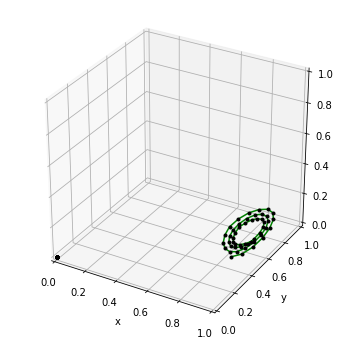

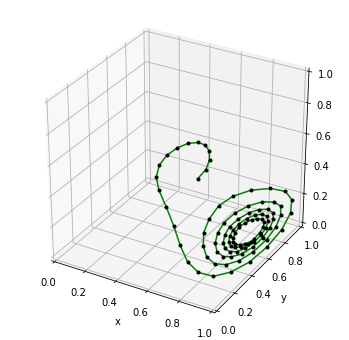

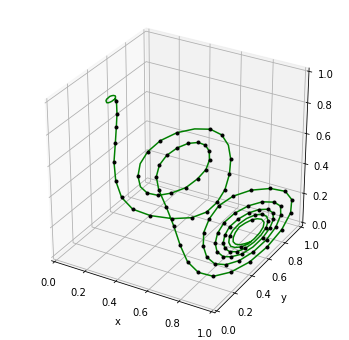

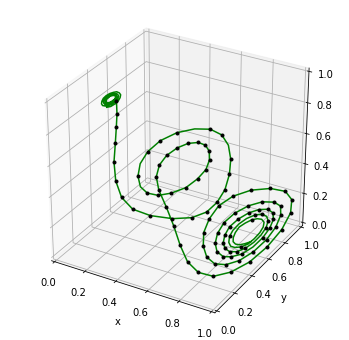

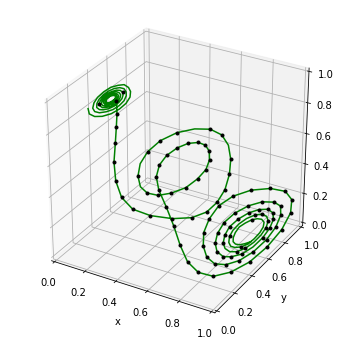

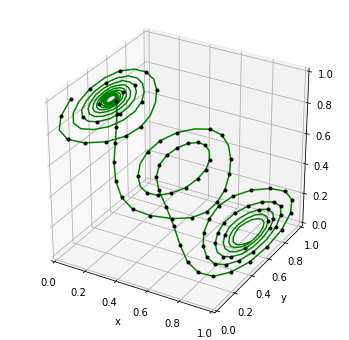

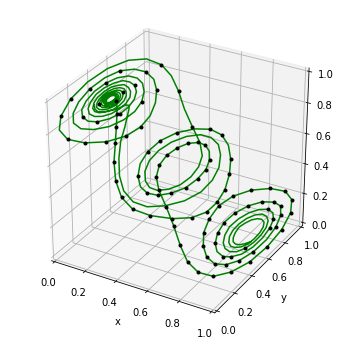

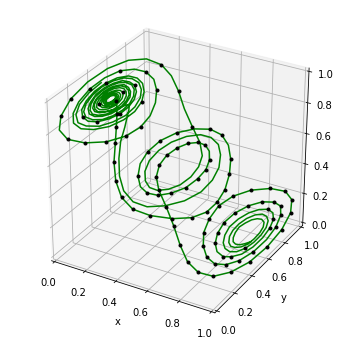

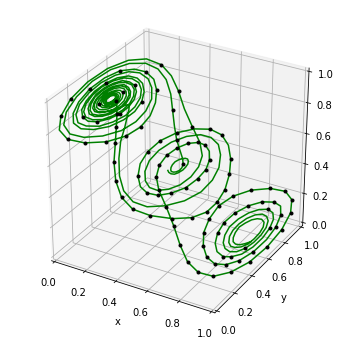

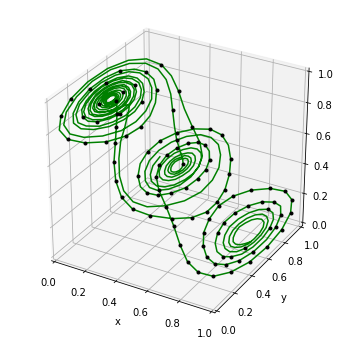

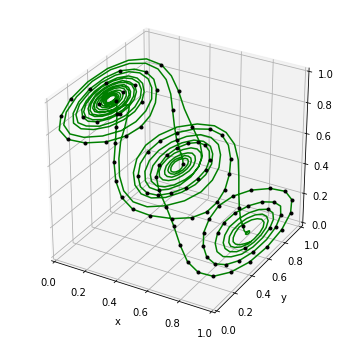

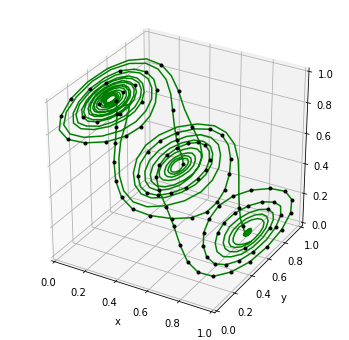

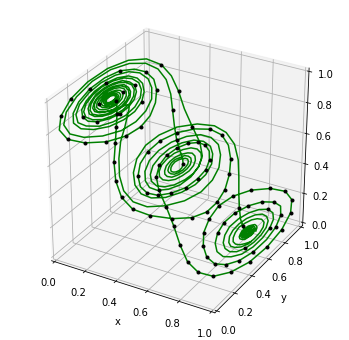

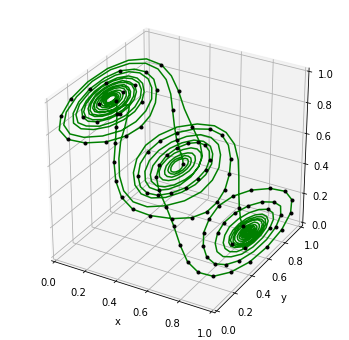

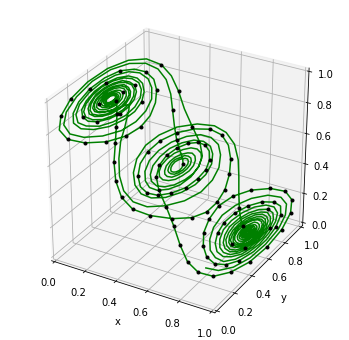

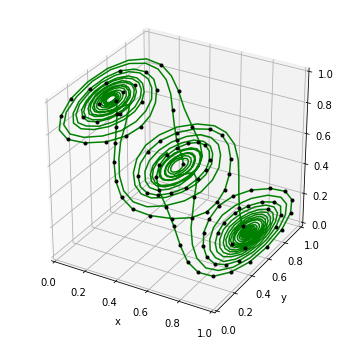

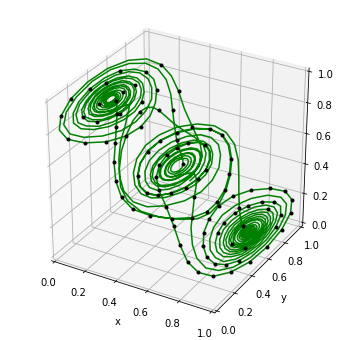

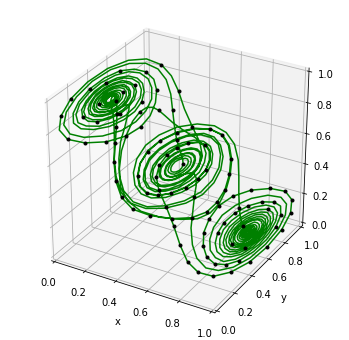

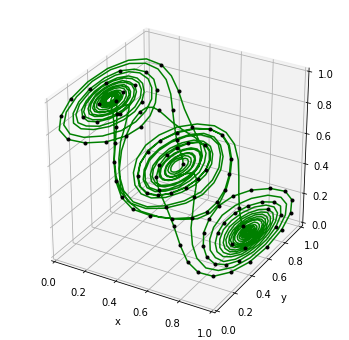

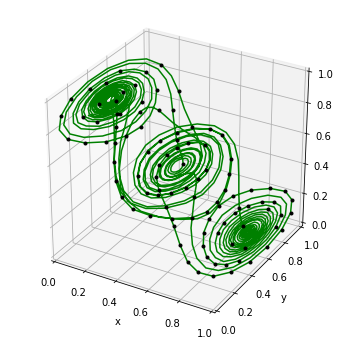

In [12]:
okm = OnlineKMeans(n_dim*n_history, 100, flag=True, random_init=False)
for i,p in enumerate(x_train.T[:1000]):
    okm.fit(p)
    if i % 50 == 49:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        plt.plot(*x_train[:3, :i+1], 'green')
        plt.xlabel('x')
        plt.ylabel('y')
        ax.set_xlim3d([0,1])
        ax.set_ylim3d([0,1])
        ax.set_zlim3d([0,1])
        plt.plot(*okm.centroid.T[:3, :], '.k')
        plt.savefig(path+'/online-{}.jpg'.format(str(i).zfill(4)))
        plt.show()

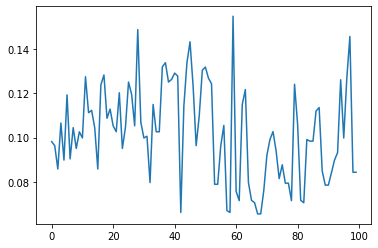

In [14]:
plt.plot(okm.centroid_dist2neighbor)

In [13]:
okm.centroid_D

array([[1.00000000e+02, 2.90321281e-01, 2.55908710e-01, ...,
        2.71966900e-01, 4.55526607e-01, 4.09054152e-01],
       [2.90321281e-01, 1.00000000e+02, 3.24634239e-01, ...,
        5.15492345e-01, 6.87805566e-01, 6.19820287e-01],
       [2.55908710e-01, 3.24634239e-01, 1.00000000e+02, ...,
        4.92092866e-01, 3.98411178e-01, 3.19279189e-01],
       ...,
       [2.71966900e-01, 5.15492345e-01, 4.92092866e-01, ...,
        1.00000000e+02, 5.17957444e-01, 5.10546167e-01],
       [4.55526607e-01, 6.87805566e-01, 3.98411178e-01, ...,
        5.17957444e-01, 1.00000000e+02, 8.43316638e-02],
       [4.09054152e-01, 6.19820287e-01, 3.19279189e-01, ...,
        5.10546167e-01, 8.43316638e-02, 1.00000000e+02]])